In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

In [140]:
rho = 9.9035e3
mu = 4*np.pi*1e-7
Omega = 2*np.pi/86400
omega = -Omega

sigma_f = 5e5
sigma_s = sigma_f
eta_f = 1/(sigma_f*mu)
eta_s = 1/(sigma_s*mu)

lambda_s = -np.sqrt(1j * omega/eta_s)

nu = 1e-2
rcmb = 3.48e6
Af = 9.0583e36 #MOI of the Core

ntheta = 1024
theta = np.linspace(0,np.pi,ntheta)

f = 2*Omega*np.cos(theta)

In [141]:
def get_diss(Br):

    lambda1_pos = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(f + omega) - 
                            np.sqrt(4*eta_f*nu*omega*(f + omega) + (Br**2/(mu*rho) + 1j*nu*omega                              + 1j*eta_f*(f + omega))**2))/(eta_f*nu))
    
    lambda1_neg = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(omega - f) - 
                            np.sqrt(4*eta_f*nu*omega*(omega - f) + (Br**2/(mu*rho) + 1j*nu*omega                              + 1j*eta_f*(omega - f))**2))/(eta_f*nu))
    
    lambda2_pos = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(f + omega) + 
                            np.sqrt(4*eta_f*nu*omega*(f + omega) + (Br**2/(mu*rho) + 1j*nu*omega                              + 1j*eta_f*(f + omega))**2))/(eta_f*nu))
    
    lambda2_neg = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(omega - f) + 
                            np.sqrt(4*eta_f*nu*omega*(omega - f) + (Br**2/(mu*rho) + 1j*nu*omega                                     + 1j*eta_f*(omega - f))**2))/(eta_f*nu))
    
    F_pos = ( (eta_f * lambda1_pos - eta_s*lambda_s) * ( 1j*omega/lambda2_pos - eta_f*lambda2_pos )  -  (eta_f * lambda2_pos - eta_s * lambda_s) * ( 1j*omega/lambda1_pos - eta_f*lambda1_pos ) )
             
    F_neg = ( (eta_f * lambda1_neg - eta_s*lambda_s) * ( 1j*omega/lambda2_neg - eta_f*lambda2_neg )  -  (eta_f * lambda2_neg - eta_s * lambda_s) * ( 1j*omega/lambda1_neg - eta_f*lambda1_neg ) )
    
    F1_pos = -(eta_f * lambda2_pos - eta_s * lambda_s)/F_pos
    F1_neg = -(eta_f * lambda2_neg - eta_s * lambda_s)/F_neg
    F2_pos = (eta_f * lambda1_pos - eta_s * lambda_s)/F_pos
    F2_neg = (eta_f * lambda1_neg - eta_s * lambda_s)/F_neg
    
    Iem = Br**2 * ( (1 + np.cos(theta))**2 * (F1_pos + F2_pos) + 
                    (1 - np.cos(theta))**2 * (F1_neg + F2_neg) )

    Ivisc = ( (1 + np.cos(theta))**2 * (1j * omega * (F1_pos + F2_pos) - eta_f * (F1_pos * lambda1_pos**2 + F2_pos * lambda2_pos**2))
             + (1 - np.cos(theta))**2 * (1j * omega * (F1_neg + F2_neg) - eta_f * (F1_neg * lambda1_neg**2 + F2_neg * lambda2_neg**2))
            )

    IemInt = (np.pi*rcmb**4)/(2*1j*Omega*Af) * 1/mu * simpson(Iem * np.sin(theta),x=theta)
    IviscInt = (np.pi*rcmb**4)/(2*1j*Omega*Af) * rho * nu * simpson(Ivisc * np.sin(theta),x=theta)
    
    return Iem, IemInt, Ivisc, IviscInt

/tmp/ipykernel_414/192501579.py:17: RuntimeWarning: divide by zero encountered in divide
  F_neg = ( (eta_f * lambda1_neg - eta_s*lambda_s) * ( 1j*omega/lambda2_neg - eta_f*lambda2_neg )  -  (eta_f * lambda2_neg - eta_s * lambda_s) * ( 1j*omega/lambda1_neg - eta_f*lambda1_neg ) )
/tmp/ipykernel_414/192501579.py:17: RuntimeWarning: invalid value encountered in divide
  F_neg = ( (eta_f * lambda1_neg - eta_s*lambda_s) * ( 1j*omega/lambda2_neg - eta_f*lambda2_neg )  -  (eta_f * lambda2_neg - eta_s * lambda_s) * ( 1j*omega/lambda1_neg - eta_f*lambda1_neg ) )
/tmp/ipykernel_414/192501579.py:20: RuntimeWarning: invalid value encountered in divide
  F1_neg = -(eta_f * lambda2_neg - eta_s * lambda_s)/F_neg
/tmp/ipykernel_414/192501579.py:22: RuntimeWarning: invalid value encountered in divide
  F2_neg = (eta_f * lambda1_neg - eta_s * lambda_s)/F_neg
/tmp/ipykernel_414/192501579.py:15: RuntimeWarning: divide by zero encountered in divide
  F_pos = ( (eta_f * lambda1_pos - eta_s*lambda_s) * ( 1j

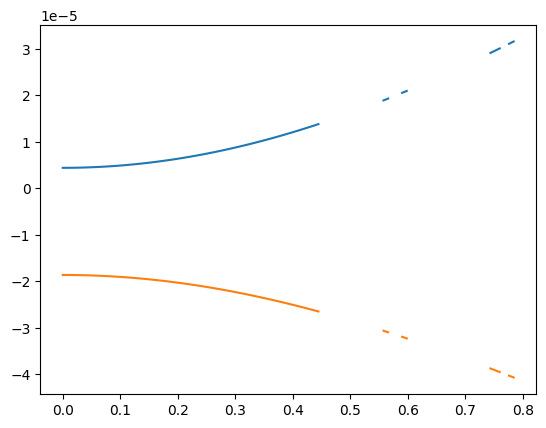

In [142]:
Br_rms = 2.09e-4
Br_dip = np.sqrt(3) * Br_rms * np.cos(theta)
Br_uni = np.linspace(0,0.8,100)*1e-3
Kcmb_real = np.zeros_like(Br_uni)
Kcmb_imag = np.zeros_like(Br_uni)

Iem_dip, IemInt_dip, Ivisc_dip, IviscInt_dip = get_diss(Br_dip)

for k, br in enumerate(Br_uni):
    Iem_uni, IemInt_uni, Ivisc_uni, IviscInt_uni = get_diss(br)
    total_diss = IemInt_uni + IviscInt_uni + IemInt_dip + IviscInt_dip
    Kcmb_real[k] = np.real(total_diss)
    Kcmb_imag[k] = np.imag(total_diss)

plt.plot(Br_uni*1e3,Kcmb_real)
plt.plot(Br_uni*1e3,Kcmb_imag)
plt.show()